In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols, glm
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Data Import
raw_data = pd.read_csv('/content/drive/MyDrive/student_math_grades.csv')
raw_data.head(2)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,higher,internet,famrel,freetime,goout,dalc,walc,health,absences,grades
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,5,3,3,1,1,3,4,6


In [3]:
# Sanity Check
print("Shape: " + str(raw_data.shape))
SC = []
for i in raw_data.columns:
  SC.append(raw_data[i].value_counts())
print(SC)

Shape: (395, 30)
[GP    349
MS     46
Name: school, dtype: int64, F    208
M    187
Name: sex, dtype: int64, 16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64, U    307
R     88
Name: address, dtype: int64, GT3    281
LE3    114
Name: famsize, dtype: int64, T    354
A     41
Name: pstatus, dtype: int64, 4    131
2    103
3     99
1     59
0      3
Name: medu, dtype: int64, 2    115
3    100
4     96
1     82
0      2
Name: fedu, dtype: int64, other       141
services    103
at_home      59
teacher      58
health       34
Name: mjob, dtype: int64, other       217
services    111
teacher      29
at_home      20
health       18
Name: fjob, dtype: int64, course        145
home          109
reputation    105
other          36
Name: reason, dtype: int64, mother    273
father     90
other      32
Name: guardian, dtype: int64, 1    257
2    107
3     23
4      8
Name: traveltime, dtype: int64, 2    198
1    105
3     65
4     27
Name: study

In [4]:
# Data Cleaning
raw_data['school'].replace({"GP":1, "MS":0}, inplace = True)
raw_data['sex'].replace({"M":1, "F":0}, inplace = True)
raw_data['address'].replace({"U":1, "R":0}, inplace = True)
raw_data['famsize'].replace({"LE3":1, "GT3":0}, inplace = True)
raw_data['pstatus'].replace({"T":1, "A":0}, inplace = True)
raw_data['schoolsup'].replace({"yes":1, "no":0}, inplace = True)
raw_data['famsup'].replace({"yes":1, "no":0}, inplace = True)
raw_data['paid'].replace({"yes":1, "no":0}, inplace = True)
raw_data['activities'].replace({"yes":1, "no":0}, inplace = True)
raw_data['nursery'].replace({"yes":1, "no":0}, inplace = True)
raw_data['higher'].replace({"yes":1, "no":0}, inplace = True)
raw_data['internet'].replace({"yes":1, "no":0}, inplace = True)
df = pd.concat([raw_data, pd.get_dummies(raw_data['mjob'], prefix = 'm', drop_first=True)], axis = 1)
df = pd.concat([df, pd.get_dummies(raw_data['fjob'], prefix = 'f', drop_first=True)], axis = 1)
df = pd.concat([df, pd.get_dummies(raw_data['reason'], prefix = 'reason', drop_first=True)], axis = 1)
df = pd.concat([df, pd.get_dummies(raw_data['guardian'], prefix = 'guardian', drop_first=True)], axis = 1)
df.drop(columns = ['mjob', 'fjob', 'reason', 'guardian'], inplace = True)

***Linear Reg - Backward Stepwise Regression***

In [5]:
# Linear Reg - Backward Stepwise Regression.
mod0 = ols('grades ~ medu + failures', data = df).fit()
print(mod0.summary())

                            OLS Regression Results                            
Dep. Variable:                 grades   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     34.13
Date:                Fri, 06 May 2022   Prob (F-statistic):           2.16e-14
Time:                        03:01:12   Log-Likelihood:                -1129.5
No. Observations:                 395   AIC:                             2265.
Df Residuals:                     392   BIC:                             2277.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4821      0.621     15.267      0.0

Adj. R-squared: 0.144 is low in terms of Marketing, but ***acceptable*** in Sociology.

**Falk and Miller (1992)** recommended that R2 values should be equal to or greater than 0.10 for the variance explained of a particular endogenous construct to be deemed adequate.
**Cohen (1988)** suggested R2 values for endogenous latent variables are assessed as follows: 0.26 (substantial), 0.13 (moderate), 0.02 (weak). 

*The there’s only one variable having a negative impact on the outcome, “failures”, which means number of past class failures. It indicates that the number of past class failures causes final failure.*

*Based on the model above, the there’s two variable having significant impact on the outcome, “medu” and “failures”.*

*According to the attribute information, we know the mother's education is out of control. Therefore, the only way is decreasing the number of past class failures of students.*

**OR% in Logistic Regressiona**

In [6]:
df['grades'].replace({20:1, 19:1, 18:1, 17:1, 16:1, 15:1, 14:1, 13:1, 
                              12:1, 11:1, 10:1, 9:1, 8:1, 7:1, 6:0, 5:1, 4:1,
                              3:1, 2:1, 1:0}, inplace = True)
df['grades'].head()

0    0
1    0
2    1
3    1
4    1
Name: grades, dtype: int64

In [7]:
y = df['grades'].values
X = df.drop('grades', axis = 1).values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
a = pd.DataFrame(X_train, columns = df.drop('grades', axis = 1).columns)
b = pd.DataFrame(y_train, columns = ['grades'] )
z = pd.concat([a,b], axis = 1)

In [43]:
mod1 = glm('grades ~ sex + failures + paid + absences',
           family =sm.families.Binomial(), data = z).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 grades   No. Observations:                  296
Model:                            GLM   Df Residuals:                      291
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.335
Date:                Fri, 06 May 2022   Deviance:                       174.67
Time:                        03:03:36   Pearson chi2:                 2.58e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4336      0.333      1.304      0.1

In [44]:
X_test = pd.DataFrame(X_test, columns = df.drop('grades', axis = 1).columns)

In [45]:
y_pred_probs = mod1.predict(X_test)

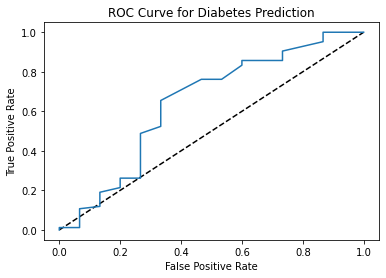

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

In [47]:
print(roc_auc_score(y_test, y_pred_probs))

0.6428571428571429


In [48]:
def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [49]:
th = sensivity_specifity_cutoff(y_test, y_pred_probs)

In [50]:
for i in range(len(y_pred_probs)):
  if y_pred_probs[i] >= th:
    y_pred_probs[i] = 1
  else:
    y_pred_probs[i] = 0

In [51]:
yp = y_pred_probs.values.astype("int")

In [52]:
print(confusion_matrix(y_test, yp))
print(classification_report(y_test, yp))

[[10  5]
 [29 55]]
              precision    recall  f1-score   support

           0       0.26      0.67      0.37        15
           1       0.92      0.65      0.76        84

    accuracy                           0.66        99
   macro avg       0.59      0.66      0.57        99
weighted avg       0.82      0.66      0.70        99



In [53]:
(np.exp(mod1.params)-1) * 100

Intercept     54.274069
sex          246.606200
failures     -47.274549
paid         342.606450
absences      25.166074
dtype: float64